# Setup
## Import and git root

In [274]:

import bw2io as bi
import bw2data as bd
import bw2calc as bc
import git


from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import re

In [275]:
def get_git_root():
    repo = git.Repo(search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")
root = get_git_root()

## Brightway reference variables

In [276]:
bd.projects.set_current('SEE_LAB') 

# Exploration
## Brightway (pre-existing)

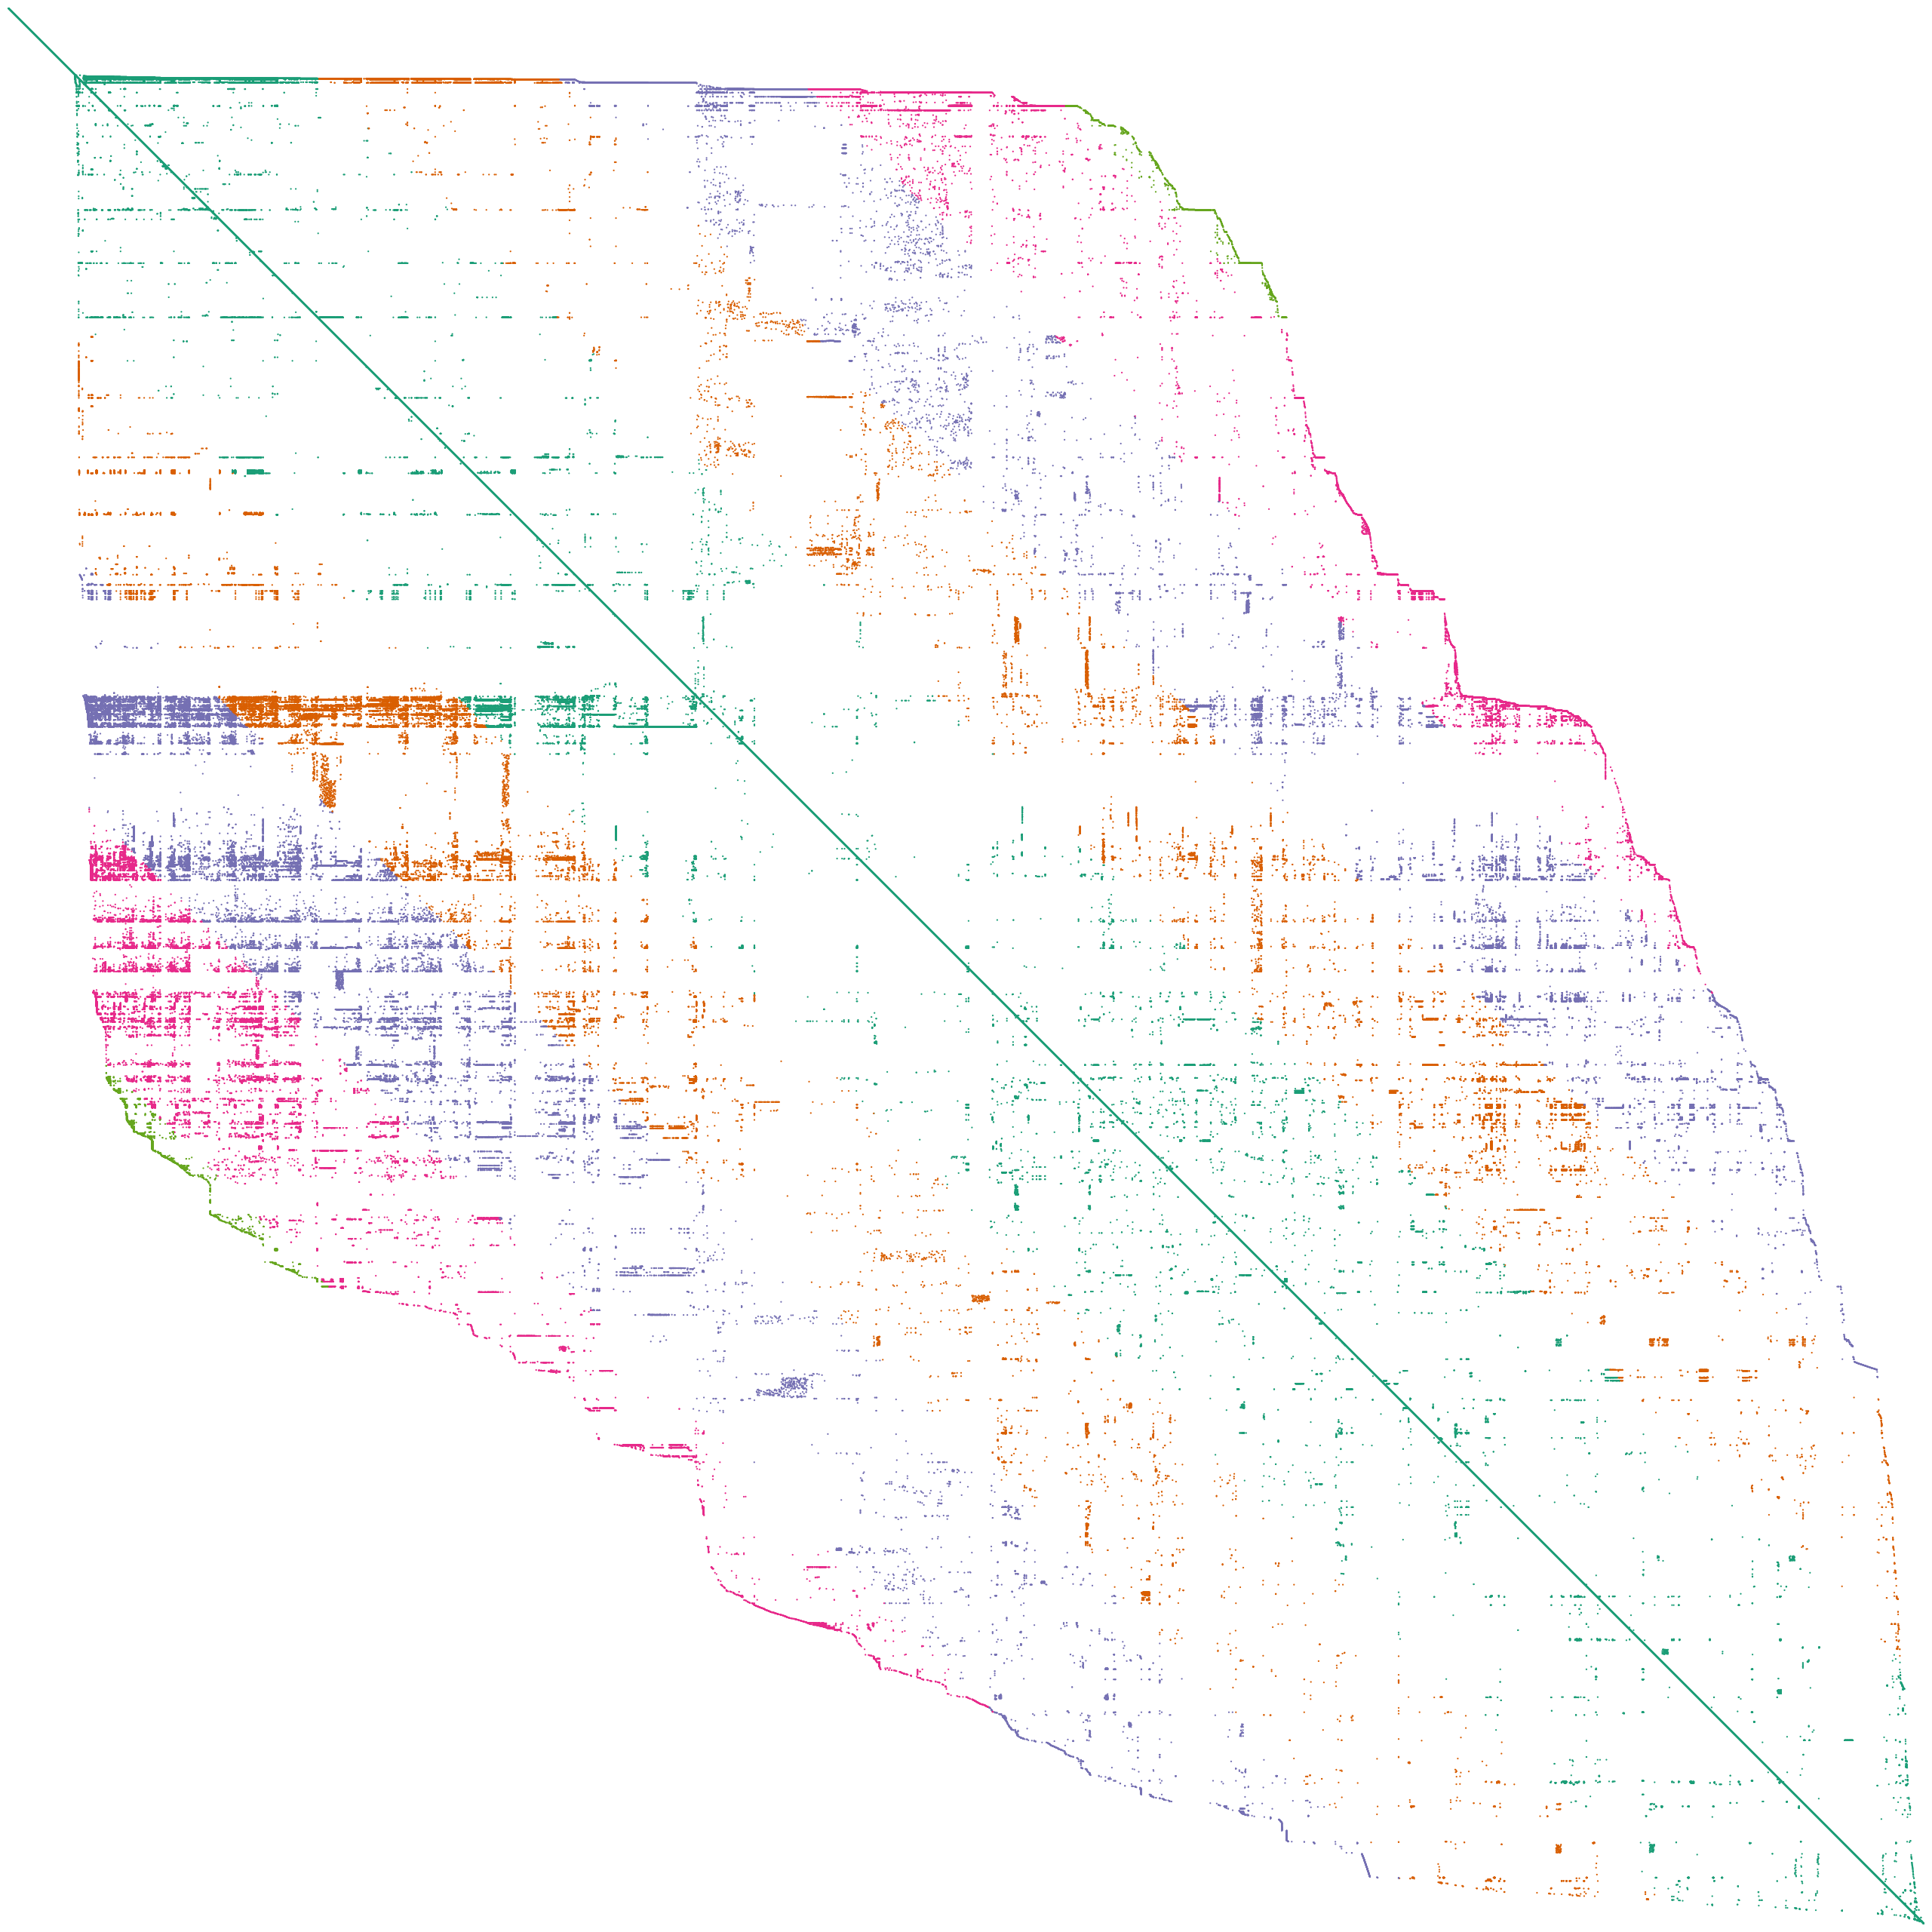

In [277]:
eidb = bd.Database("ecoinvent-3.11-cutoff")
eidb.graph_technosphere()


What this graphed technosphere means:

* Rox of pixels represent inputs to processes
* Columns of pixels represent outputs from processes
* (colors) represent the flow of materials, energy, or emissions between them.

In [278]:
random_act = eidb.random()
random_act.as_dict()

{'comment': 'The multi-output-process "precious metal refining, secondary copper" delivers the co-products "silver, secondary, at precious metal refinery", "gold, secondary, at precious metal refinery" and "palladium, secondary, at precious metal refinery". The flows "silver, …" and "gold, …" are part of the global supply mix of gold and silver modelled in this part. The by-product "palladium, …" receives its part of the burdens, but it is not aimed to be used by the data-user.\n[This dataset was already contained in the ecoinvent database version 2. It was not individually updated during the transfer to ecoinvent version 3. Life Cycle Impact Assessment results may still have changed, as they are affected by changes in the supply chain, i.e. in other datasets. This dataset was generated following the ecoinvent quality guidelines for version 2. It may have been subject to central changes described in the ecoinvent version 3 change report (http://www.ecoinvent.org/database/ecoinvent-vers

In [279]:
for exc in random_act.exchanges():
    print(exc)

Exchange: 1.0 kilogram 'treatment of precious metal from electronics scrap, in anode slime, precious metal extraction' (kilogram, SE, None) to 'treatment of precious metal from electronics scrap, in anode slime, precious metal extraction' (kilogram, SE, None)>
Exchange: 17.002387241882378 kilowatt hour 'market for electricity, high voltage' (kilowatt hour, SE, None) to 'treatment of precious metal from electronics scrap, in anode slime, precious metal extraction' (kilogram, SE, None)>
Exchange: 2.1345323099830176 megajoule 'market for heat, district or industrial, other than natural gas' (megajoule, Europe without Switzerland, None) to 'treatment of precious metal from electronics scrap, in anode slime, precious metal extraction' (kilogram, SE, None)>
Exchange: 0.6535783250870936 kilogram 'market for oxygen, liquid' (kilogram, RER, None) to 'treatment of precious metal from electronics scrap, in anode slime, precious metal extraction' (kilogram, SE, None)>
Exchange: 12.47876830917142 k

In [280]:
[exc for exc in random_act.exchanges()][0].as_dict()


{'flow': 'e09971fb-f77e-48a3-99a8-4feba6a59bb4',
 'type': 'production',
 'name': 'gold',
 'classifications': {'CPC': ['41320: Gold (including gold plated with platinum), unwrought or in semi-manufactured forms, or in powder form']},
 'production volume': 37.7675237545915,
 'properties': {'allocation factor': {'amount': 0.3489100603710728,
   'unit': 'dimensionless'},
  'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'carbon content, fossil': {'amount': 0.0,
   'comment': 'Au',
   'unit': 'dimensionless'},
  'carbon content, non-fossil': {'amount': 0.0,
   'comment': 'Au',
   'unit': 'dimensionless'},
  'dry mass': {'amount': 1.0, 'unit': 'kg'},
  'price': {'amount': 35305.53,
   'comment': 'This price is based on an average price from 2017 to 2022 data from USGS (https://www.usgs.gov/centers/national-minerals-information-center/gold-statistics-and-information). . Last access: July 2024. The prices were converted to EUR

## Original (trivial)
### Process Charts
First we'll look at all the technosphere processes

In [281]:
## Create a dictionary of all the country codes counts (from the technosphere activities) and convert to a dataframe
global_dict = defaultdict(int)
for act in eidb:
    cc_code = act['location']
    global_dict[cc_code] += 1

country_frame  = pd.DataFrame(list(global_dict.items()), columns=['Country', 'Process Count'])
country_frame

,Country,Process Count
0,GLO,4543
1,RoW,4673
2,RER,2272
3,SK,99
4,CA-QC,420
...,...,...
327,RER w/o CH+DE,3
328,ENTSO-E,3
329,IN-DD,1
330,Europe without Switzerland and Austria,2


We want to look at these as a map; this requires:
* shapefiles for each country region (eg a global shapefile with provinces included)
* a dictionary or map to get from each country code to each shapefile 

Luckily, the database overview has a geographies sheet to match what this includes. We merge this now. 

In [ ]:
geographies = pd.read_excel(f"{root}/Data/Database-Overview-for-ecoinvent-v3.10_29.04.24.xlsx", sheet_name="Geographies")
country_frame = pd.merge(
    left=country_frame,
    right=geographies,
    how='inner',
    left_on='Country',
    right_on='Shortname'
)

## Clean the frame a bit further. 
country_frame.drop(columns='Country', inplace=True)
country_frame.sort_values(by='Process Count', ascending=False).head(10)

## get the country code from the name
def get_basename(text):
    text = str(text)
    if len(text) == 2:
        return text
    match = re.search(r"..-", text)
    return match.group(0)[:2] if match else None

country_frame['base_name'] = country_frame['Shortname'].apply(get_basename)
country_frame.sort_values(by='Process Count', ascending=False).head(10)


GLO
RoW
RER
SK
CA-QC
US-MN
PT
CH
CN-HL
CA-BC
BD
IN-OR
SE
BR-TO
IN
IR
GB
NG
FR
TG
RAS
IT
US
BR-RR
ZA
BA
CN-FJ
PE
NL
CA-NT
SI
CO
MK
KW
RU
BR-MA
IS
IN-KA
CA-NS
IN-MH
ES
DZ
Europe without Switzerland
CA-AB
CN-JS
BR-SP
UN-OCEANIA
BG
US-ND
RoE
BR
IN-AP
CA-NF
RO
AR
CN
IL
IAI Area, North America
CY
IN-UP
JP
IN-TN
IAI Area, EU27 & EFTA
BR-ES
CN-GD
CN-ZJ
DE
MT
LT
CA-SK
DK
HU
CA-MB
ME
US-SERC
BE
IE
CN-HA
BR-PA
CA-PE
CN-SC
IN-North-eastern grid
ET
IN-GA
FI
RLA
CA-NU
LV
BR-AP
CN-SA
AU-WA
BR-South-eastern/Mid-western grid
CL
BR-SC
RNA
UN-SEASIA
KR
LY
RER w/o DE+NL+RU
US-RFC
EE
CZ
BR-Southern grid
CN-QH
BH
UZ
NZ
TR
BR-CE
TH
CN-GX
BR-MT
PL
CG
TW
NI
ID
MY
TN
EC
US-MRO
BR-GO
AZ
KE
CA-ON
AU-SA
BJ
BR-Northern grid
CA
MX
BR-North-eastern grid
WECC
GR
BR-RO
NO
AU-VIC
BR-AC
UA
MU
US-WECC
HR
CN-GZ
IN-GJ
US-WA
RER w/o RU
AU
CN-CSG
IAI Area, South America
PA
GA
MZ
CN-SX
US-ASCC
BR-PB
IAI Area, Russia & RER w/o EU27 & EFTA
BR-RS
RS
North America without Quebec
OM
PH
IN-WB
MA
BR-PR
CN-NM
AT
SS
CR
HK
CN-SWG
BR-SE


,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,base_name
1,4673,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN,None
0,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,None
7,2710,131278d6-7d7e-11de-9ae2-0019e336be3a,Switzerland,CH,46.861000,7.908000,Country,NaN,CH
2,2272,0723d252-7e2a-11de-9820-0019e336be3a,Europe,RER,59.970128,78.961769,ecoinvent Region,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,None
42,620,f9221622-cc45-11de-98ed-0019e336be3a,Europe without Switzerland,Europe without Switzerland,48.597508,6.421103,ecoinvent Custom Area,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,None
55,422,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.420000,106.514000,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,CN
4,420,868a66d1-7428-4ba2-9125-253b07afc119,"Canada, Québec",CA-QC,53.390446,-71.755869,Province or State,NaN,CA
22,326,13d387f6-7d7e-11de-9ae2-0019e336be3a,United States of America,US,39.622000,-98.606000,Country,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,US
50,312,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,Brazil,BR,-10.772000,-53.089000,Country,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...,BR
24,297,12b21766-7d7e-11de-9ae2-0019e336be3a,South Africa,ZA,-30.558000,23.121000,Country,NaN,ZA


In [283]:
def get_basenames(text):
    return [get_basename(item) for item in text.split(";")]


country_frame['Contained_Geographies_List'] = country_frame['Contained and Overlapping Geographies'].apply(get_basename)

AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; AR; AS; Asia without China; AT; AU; AU-AC; AU-ACT; AU-IOT; AU-JBT; AU-NSW; AU-NT; AU-QLD; AU-SA; AU-TAS; AU-VIC; AU-WA; AW; AX; AZ; BA; Bajo Nuevo; BALTSO; BB; BD; BE; BF; BG; BH; BI; BJ; BL; BM; BN; BO; BQ; BR; BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-DF; BR-ES; BR-GO; BR-MA; BR-MG; BR-Mid-western grid; BR-MS; BR-MT; BR-North-eastern grid; BR-Northern grid; BR-PA; BR-PB; BR-PE; BR-PI; BR-PR; BR-RJ; BR-RN; BR-RO; BR-RR; BR-RS; BR-SC; BR-SE; BR-South-eastern grid; BR-South-eastern/Mid-western grid; BR-Southern grid; BR-SP; BR-TO; BS; BT; BV; BW; BY; BZ; CA; CA-AB; CA-BC; CA-MB; Canada without Alberta; Canada without Alberta and Quebec; Canada without Quebec; Canary Islands; CA-NB; CA-NF; CA-NS; CA-NT; CA-NU; CA-ON; CA-PE; CA-QC; CA-SK; CA-YK; CC; CD; Central Asia; CENTREL; CF; CG; CH; China w/o Inner Mongol; CI; CK; CL; Clipperton Island; CM; CN; CN-AH; CN-BJ; CN-CCG; CN-CQ; CN-CSG; CN-ECGC; CN-FJ; CN-GD; CN-GS; CN-GX; CN-GZ; CN-HA; CN-H

TypeError: object of type 'float' has no len()

In [269]:
cont_codes = pd.read_csv(f"{root}/Data/indexing_csvs/country-and-continent-codes-list.csv")
cont_codes

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0
...,...,...,...,...,...,...
257,Africa,AF,"Zambia, Republic of",ZM,ZMB,894.0
258,Oceania,OC,Disputed Territory,XX,NaN,NaN
259,Asia,AS,Iraq-Saudi Arabia Neutral Zone,XE,NaN,NaN
260,Asia,AS,United Nations Neutral Zone,XD,NaN,NaN


In [270]:
--break

SyntaxError: invalid syntax (2613166702.py, line 1)

In [233]:
country_frame['Contained and Overlapping Geographies'].value_counts().reset_index().merge(country_frame, on='Contained and Overlapping Geographies').sort_values('Process Count', ascending=False).head(10)

,Contained and Overlapping Geographies,count,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,base_name,Continent,Region,Country,Capital,FIPS,ISO (2),ISO (3),ISO (No),Internet,Note
3,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,1,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
6,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,1,2272,0723d252-7e2a-11de-9820-0019e336be3a,Europe,RER,59.970128,78.961769,ecoinvent Region,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
10,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,1,620,f9221622-cc45-11de-98ed-0019e336be3a,Europe without Switzerland,Europe without Switzerland,48.597508,6.421103,ecoinvent Custom Area,None,Europe,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
14,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,1,422,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.420000,106.514000,Country,CN,Asia,East Asia,China,Beijing,CH,CN,CHN,156,CN,2
4,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,1,326,13d387f6-7d7e-11de-9ae2-0019e336be3a,United States of America,US,39.622000,-98.606000,Country,US,Americas,North America,United States,"Washington, DC",US,US,USA,840,US,
5,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...,1,312,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,Brazil,BR,-10.772000,-53.089000,Country,BR,Americas,South America,Brazil,Brasilia,BR,BR,BRA,076,BR,
9,IN-AN; IN-AP; IN-AR; IN-AS; IN-BR; IN-CH; IN-C...,1,268,0e6a7860-7d7e-11de-9ae2-0019e336be3a,India,IN,21.000000,78.500000,Country,IN,Asia,South Asia,India,New Delhi,IN,IN,IND,356,IN,
11,Canary Islands,1,170,12ea642c-7d7e-11de-9ae2-0019e336be3a,Spain,ES,40.227000,-3.649000,Country,ES,Europe,South West Europe,Spain,Madrid,SP,ES,ESP,724,ES,
15,Asia without China; Europe without Austria; Eu...,1,117,12143bfe-7d7e-11de-9ae2-0019e336be3a,Russia,RU,61.847380,97.037378,Country,RU,Asia,Northern Asia,Russia,Moscow,RS,RU,RUS,643,RU,
8,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,1,107,0fecb5e8-7e2a-11de-9820-0019e336be3a,Northern America,RNA,58.710600,-91.968294,UN Subregion,None,Africa,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,


Explore the distribution a little 

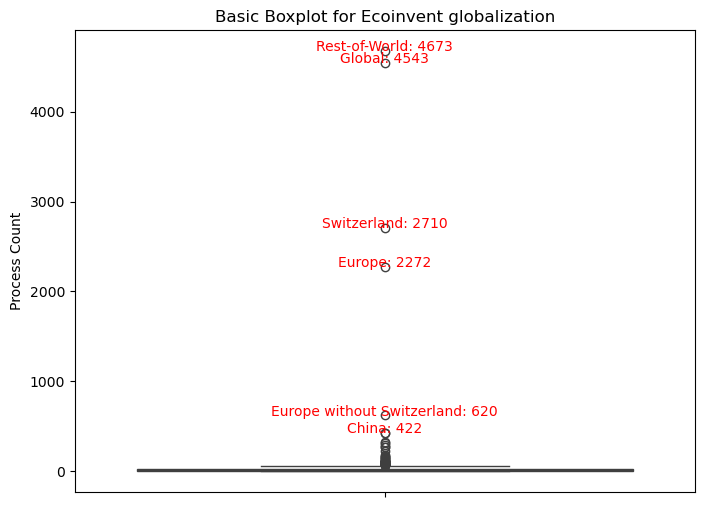

In [ ]:
top5 = country_frame.sort_values(by='Process Count', ascending=False).head(6).copy()

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=country_frame, y='Process Count')

for i, outlier in top5.iterrows():
    plt.text(0, outlier['Process Count'], f"{outlier['Name']}: {outlier['Process Count']}", color='red', ha='center')

plt.title("Basic Boxplot for Ecoinvent globalization")
plt.show()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0
...,...,...,...,...,...,...
257,Africa,AF,"Zambia, Republic of",ZM,ZMB,894.0
258,Oceania,OC,Disputed Territory,XX,NaN,NaN
259,Asia,AS,Iraq-Saudi Arabia Neutral Zone,XE,NaN,NaN
260,Asia,AS,United Nations Neutral Zone,XD,NaN,NaN


Note that:

* Global means global average production -- it **always** means that.
* Rest of World (RoW) means all the activites NOT explicitly locally defined. For example, if you have Switzerland and USA, than RoW means the global average minus those countries (from both numerator and denominator). Importantly, this means that RoW is **different** for every process (because they have different amounts of regional data)
* RoW values are not included if the regional values leave <.5% of the global production volume.

This means that in order to map RoW accurately we'd have to 'subtract' the process values we have (for that process). Luckily, at present, this seems like it wouldn't be that useful.

Source: https://support.ecoinvent.org/geographies

In [190]:

# Merge country frame with continent information (from iso_cont)
iso_cont = pd.read_csv(f"{root}/Data/indexing_csvs/iso_to_continent.tsv", sep='\t')
country_frame = pd.merge(
    left=country_frame,
    right=iso_cont,
    how='left',
    left_on='base_name',
    right_on='ISO (2)'
)

#  Create better continent layers
mask = country_frame['Geography Classification'].str.contains(r'Country|Province|State|UN', case=False, na=False)
country_frame.loc[~mask, 'Continent'] = 'Global'

mask = country_frame['Shortname'].str.contains('Europe', case=False, na=False)
country_frame.loc[mask, 'Continent'] = 'Europe'

# Check the first row to see changes
country_frame.head(10)


,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,base_name,Continent,Region,Country,Capital,FIPS,ISO (2),ISO (3),ISO (No),Internet,Note
0,14,77b2f7ee-3f79-4946-a2d7-50c46d1756d2,"IAI Area, Asia, without China and GCC","IAI Area, Asia, without China and GCC",NaN,NaN,Aluminium Industry,AZ; Central Asia; FSU; ID; IN; IN-AN; IN-AP; I...,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
1,4673,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
2,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,


In [191]:
country_frame['Geography Classification'].value_counts()

Geography Classification
Country                  143
Province or State        126
Electricity Grid          30
ecoinvent Custom Area     10
Aluminium Industry         7
UN Subregion               6
ecoinvent Region           4
UN Region                  2
Miscellaneous              2
World                      1
Name: count, dtype: int64

In [211]:
country_frame['Region'].value_counts()


Region
East Asia            44
South Asia           43
South America        41
North America        40
Southern Africa      37
South West Asia      18
Pacific               9
South East Asia       9
Western Africa        9
South East Europe     8
Eastern Europe        7
Western Europe        7
Central America       7
Northern Africa       6
Central Europe        5
Northern Europe       5
West Indies           5
Central Asia          5
Eastern Africa        5
South West Europe     3
Southern Europe       2
Northern Asia         2
Indian Ocean          2
Central Africa        2
Name: count, dtype: int64

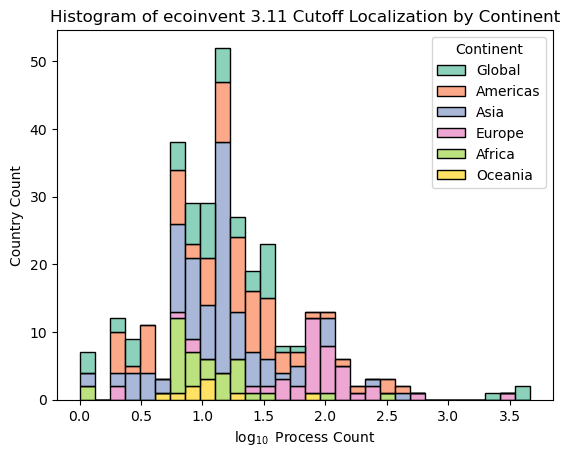

In [205]:
# Stacked histogram with hue for coloring
sns.histplot(
    data=country_frame,
    x=country_frame['Process Count'].apply(np.log10),  # Log-transform
    hue='Continent',                                 
    multiple='stack',                                 
    bins=30,
    palette='Set2'                                  
)

# Labels and title
plt.xlabel(r"$\log_{10}$ Process Count")
plt.ylabel("Country Count")
plt.title("Histogram of ecoinvent 3.11 Cutoff Localization by Continent")

plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/ecoinvent_localization_hist.png", bbox_inches='tight')

plt.show()

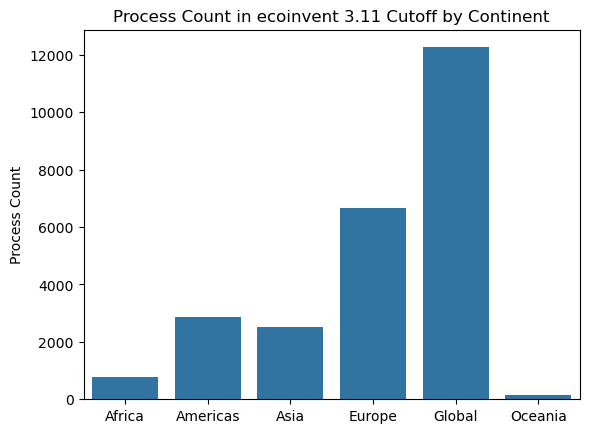

In [219]:
continent_frame = country_frame.groupby(country_frame['Continent'])['Process Count'].sum().reset_index()
sns.barplot(data=continent_frame, x='Continent', y='Process Count')
plt.xlabel("")
plt.title("Process Count in ecoinvent 3.11 Cutoff by Continent")
plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/Process_count_by_continent.png")
plt.show()

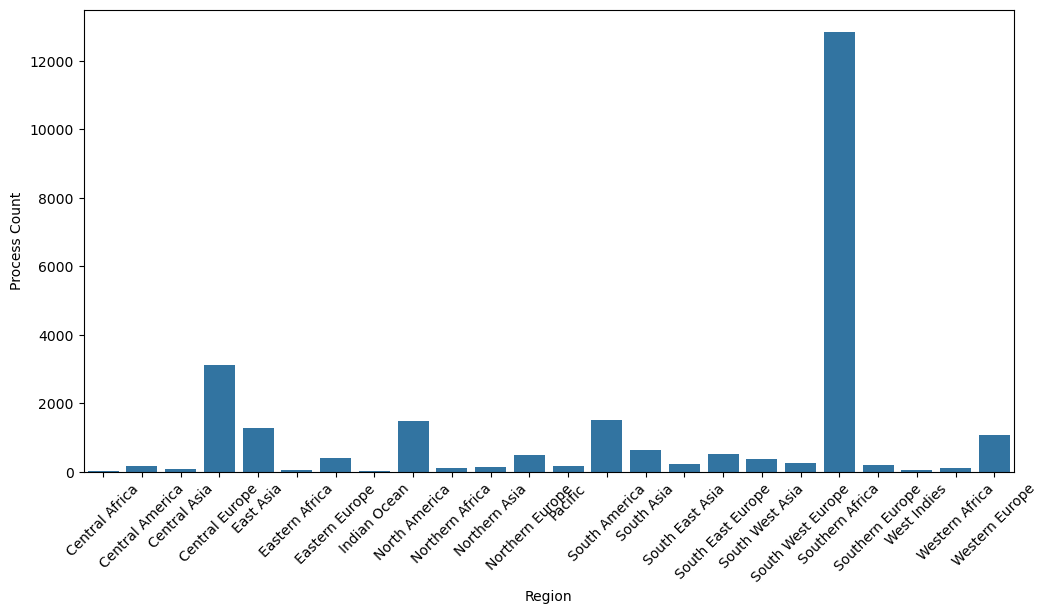

In [ ]:
region_frame = country_frame.groupby(country_frame['Region'])['Process Count'].sum().reset_index()
plt.figure(figsize=(12, 6)) 
sns.barplot(data=region_frame, x='Region', y='Process Count')
plt.xticks(rotation=45)
plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/Process_count_by_region.png")
plt.show()

In [222]:
country_frame

,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,base_name,Continent,Region,Country,Capital,FIPS,ISO (2),ISO (3),ISO (No),Internet,Note
0,14,77b2f7ee-3f79-4946-a2d7-50c46d1756d2,"IAI Area, Asia, without China and GCC","IAI Area, Asia, without China and GCC",NaN,NaN,Aluminium Industry,AZ; Central Asia; FSU; ID; IN; IN-AN; IN-AP; I...,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
1,4673,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
2,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
3,4,53b04726-ffcb-4dc7-97ab-85e7fd150d17,"United States of America, Nebraska",US-NE,NaN,NaN,Province or State,MRO; US-MRO; US-WECC; WECC,US,Americas,North America,United States,"Washington, DC",US,US,USA,840,US,
4,326,13d387f6-7d7e-11de-9ae2-0019e336be3a,United States of America,US,39.622000,-98.606000,Country,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,US,Americas,North America,United States,"Washington, DC",US,US,USA,840,US,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,2,fe0113e8-7e2d-11de-9820-0019e336be3a,Nordic Countries Power Association,NORDEL,63.764116,18.883737,Electricity Grid,"DK; FI; IAI Area, EU27 & EFTA; NO; RER w/o DE+...",None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
327,1,6d696e3b-ac91-486c-8f04-349c496915ae,Russia (Asia),Russia (Asia),NaN,NaN,ecoinvent Region,NaN,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
328,3,4c9baec2-f9fc-4f36-84f7-a3ed2eab82a1,"China, State Grid Corporation of China",CN-SGCC,NaN,NaN,Electricity Grid,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,CN,Global,East Asia,China,Beijing,CH,CN,CHN,156,CN,2
329,1,653869da-6e3f-476e-9380-19d23040f2b9,"India, Daman and Diu",IN-DD,NaN,NaN,Province or State,NaN,IN,Asia,South Asia,India,New Delhi,IN,IN,IND,356,IN,


In [ ]:
sns.scatterplot(data=country_frame, y='Process Count', y='')

### Geomapping 

In [ ]:
states = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_states_provinces_all/ne_10m_admin_1_states_provinces.shp")
states.head(3)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 states provinces,3,ARG-1309,1309,AR-E,None,AR,1,Entre Ríos,Entre-Rios,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,Admin-1 states provinces,6,URY-8,8,UY-PA,None,UY,1,Paysandú,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20012 -32.4472, -58.20011 -32.44..."
2,Admin-1 states provinces,2,IDN-1185,1185,ID-KI,None,ID,5,Kalimantan Timur,Kaltim,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."


In [195]:
countries = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_countries_all/ne_10m_admin_0_countries.shp")
# for col in countries.columns:
#     print(col)
countries[countries['ISO_A2'] == 'US']

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
154,Admin-0 country,0,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532..."


In [196]:
country_frame.shape

(331, 19)

In [ ]:
country_frame

,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,base_name,Continent,Region,Country,Capital,FIPS,ISO (2),ISO (3),ISO (No),Internet,Note
0,14,77b2f7ee-3f79-4946-a2d7-50c46d1756d2,"IAI Area, Asia, without China and GCC","IAI Area, Asia, without China and GCC",NaN,NaN,Aluminium Industry,AZ; Central Asia; FSU; ID; IN; IN-AN; IN-AP; I...,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
1,4673,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
2,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
3,4,53b04726-ffcb-4dc7-97ab-85e7fd150d17,"United States of America, Nebraska",US-NE,NaN,NaN,Province or State,MRO; US-MRO; US-WECC; WECC,US,Americas,North America,United States,"Washington, DC",US,US,USA,840,US,
4,326,13d387f6-7d7e-11de-9ae2-0019e336be3a,United States of America,US,39.622000,-98.606000,Country,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,US,Americas,North America,United States,"Washington, DC",US,US,USA,840,US,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,2,fe0113e8-7e2d-11de-9820-0019e336be3a,Nordic Countries Power Association,NORDEL,63.764116,18.883737,Electricity Grid,"DK; FI; IAI Area, EU27 & EFTA; NO; RER w/o DE+...",None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
327,1,6d696e3b-ac91-486c-8f04-349c496915ae,Russia (Asia),Russia (Asia),NaN,NaN,ecoinvent Region,NaN,None,Global,Southern Africa,Namibia,Windhoek,WA,NaN,NAM,516,NaN,
328,3,4c9baec2-f9fc-4f36-84f7-a3ed2eab82a1,"China, State Grid Corporation of China",CN-SGCC,NaN,NaN,Electricity Grid,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,CN,Global,East Asia,China,Beijing,CH,CN,CHN,156,CN,2
329,1,653869da-6e3f-476e-9380-19d23040f2b9,"India, Daman and Diu",IN-DD,NaN,NaN,Province or State,NaN,IN,Asia,South Asia,India,New Delhi,IN,IN,IND,356,IN,


In [198]:
# all_frame = county_frame.groupby()

In [199]:
matched_territories = pd.merge(
    left = country_frame,
    right = states,
    how = 'inner',
    left_on = 'Shortname',
    right_on = 'iso_3166_2'
)
matched_territories

countries_left = country_frame[~country_frame['Shortname'].isin(matched_territories['Shortname'])]
countries_left

matched_countries = pd.merge(
    left = countries_left,
    right = countries,
    how = 'inner',
    left_on = 'Shortname',
    right_on = 'ISO_A2'
)


grouped = matched_territories.groupby(matched_territories['Shortname'].str[:2])['Process Count'].sum().reset_index()
grouped
matched_added = pd.merge(
    matched_countries, grouped, on='Shortname', how='outer', suffixes=('_df1', '_df2'))
matched_added
matched_added['Process Count'] = matched_added['Process Count_df1'].fillna(0) + matched_added['Process Count_df2'].fillna(0)

In [200]:
country_frame[country_frame['Name'] == 'China']


,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,base_name,Continent,Region,Country,Capital,FIPS,ISO (2),ISO (3),ISO (No),Internet,Note
49,422,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.42,106.514,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,CN,Asia,East Asia,China,Beijing,CH,CN,CHN,156,CN,2


In [201]:
## set up a dictionary, convert everything to coordinates
frames = {
    "country-level processes in ecoinvent 3.11 cutoff technosphere" : matched_countries,
    "territory-level processes in ecoinvent 3.11 cutoff technosphere" : matched_territories,
    "all processes in ecoinvent 3.11 cutoff technosphere, with territory specific rolled into countries" : matched_added
}

for name, frame in frames.items():
    frame = gpd.GeoDataFrame(frame, geometry='geometry')
    frame.set_crs('EPSG:4326', allow_override=True, inplace=True)
    frames[name] = frame



In [202]:
def plot_heatmap_frame(frame, ax):
    # Get colors and plot them
    ax.axis("off")
    cm = mpl.colormaps.get_cmap("YlOrRd")
    norm = mpl.colors.LogNorm(vmin=1, vmax=10**4)

    ## Dynamic Norming (left for posterity)
    # norm = mpl.colors.LogNorm(vmin=frame['Process Count'].min(), vmax=frame['Process Count'].max())

    frame.plot(column='Process Count', norm=norm, cmap=cm, ax=ax,
               edgecolor='black',
                linewidth = 0.3 )
    
    countries = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_countries_all/ne_10m_admin_0_countries.shp")
    countries.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.2)

    
    ## Dynamic Colorbar 
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm._A = []  
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.0)
    cbar.set_label('Process Count')  



In [203]:

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


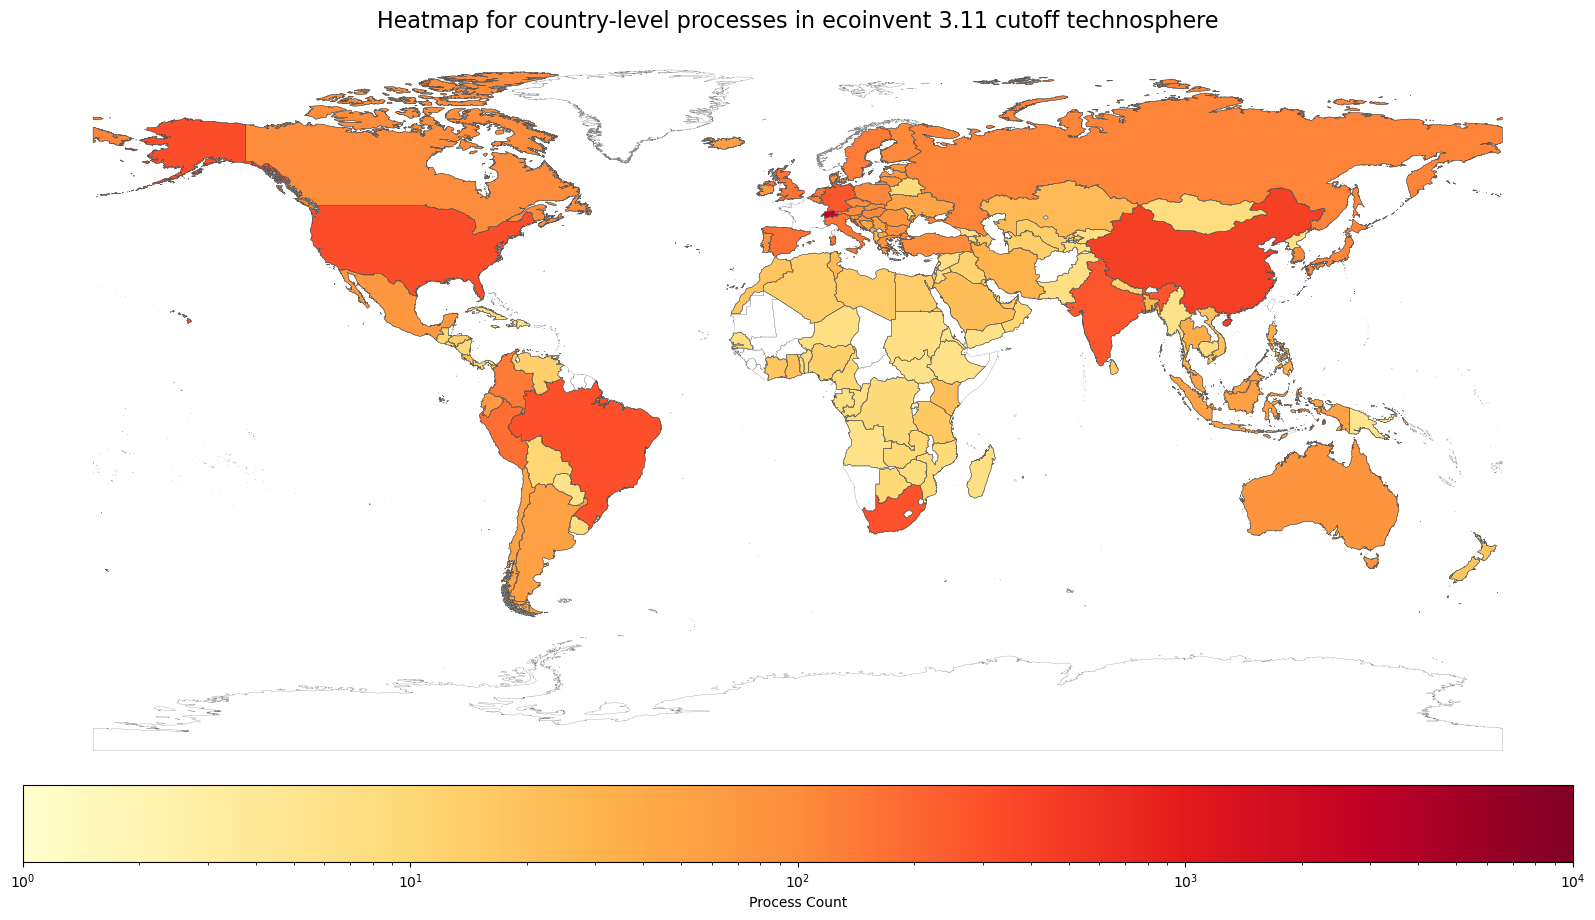

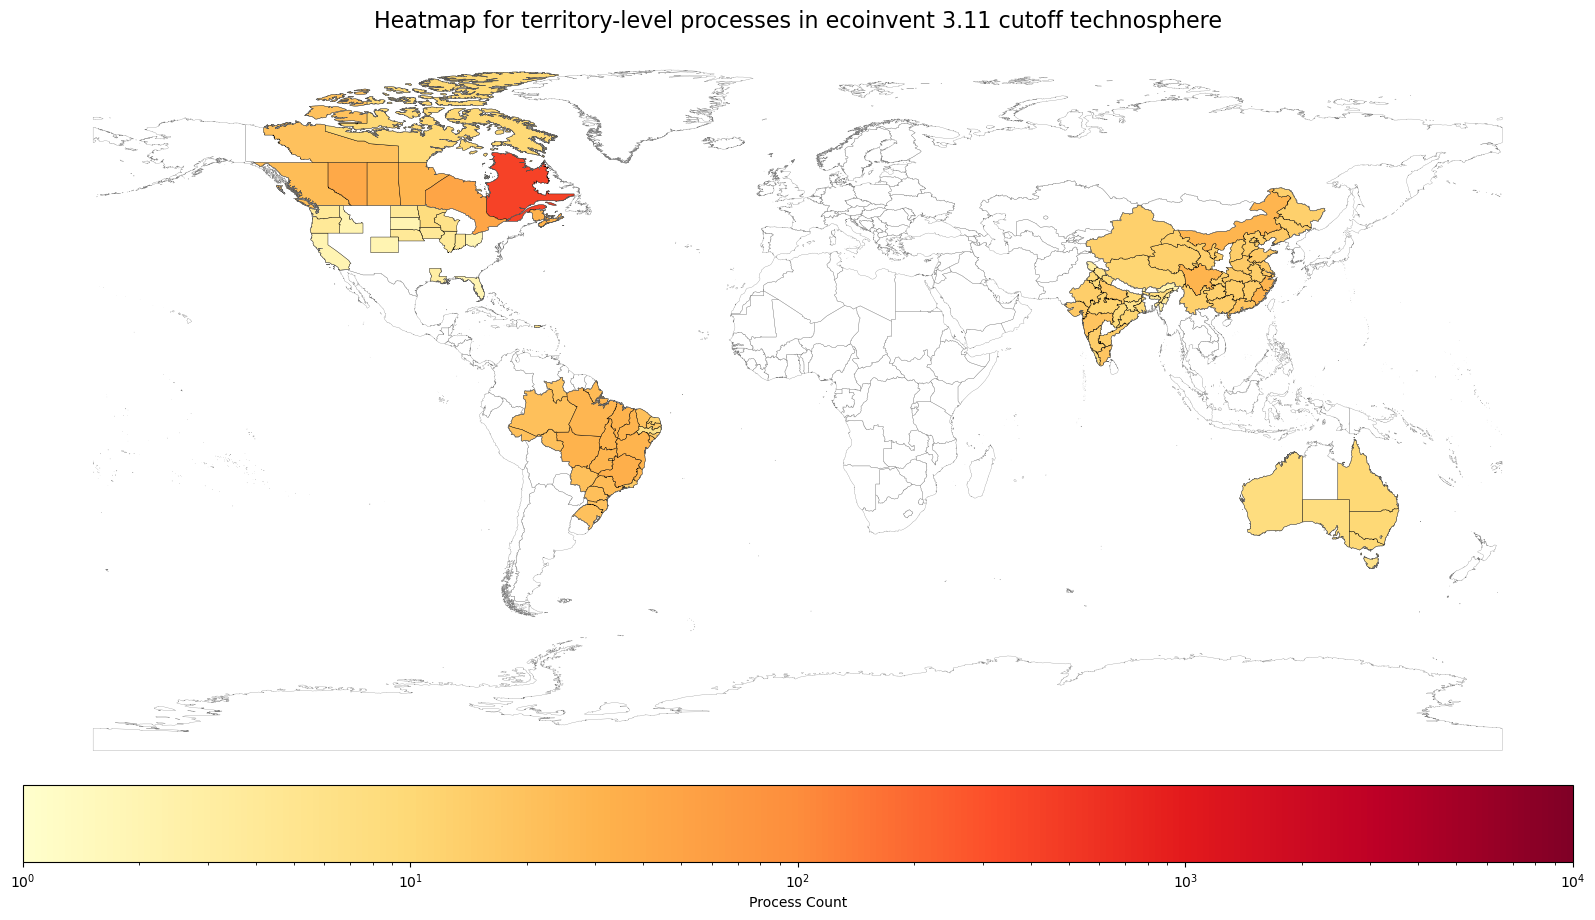

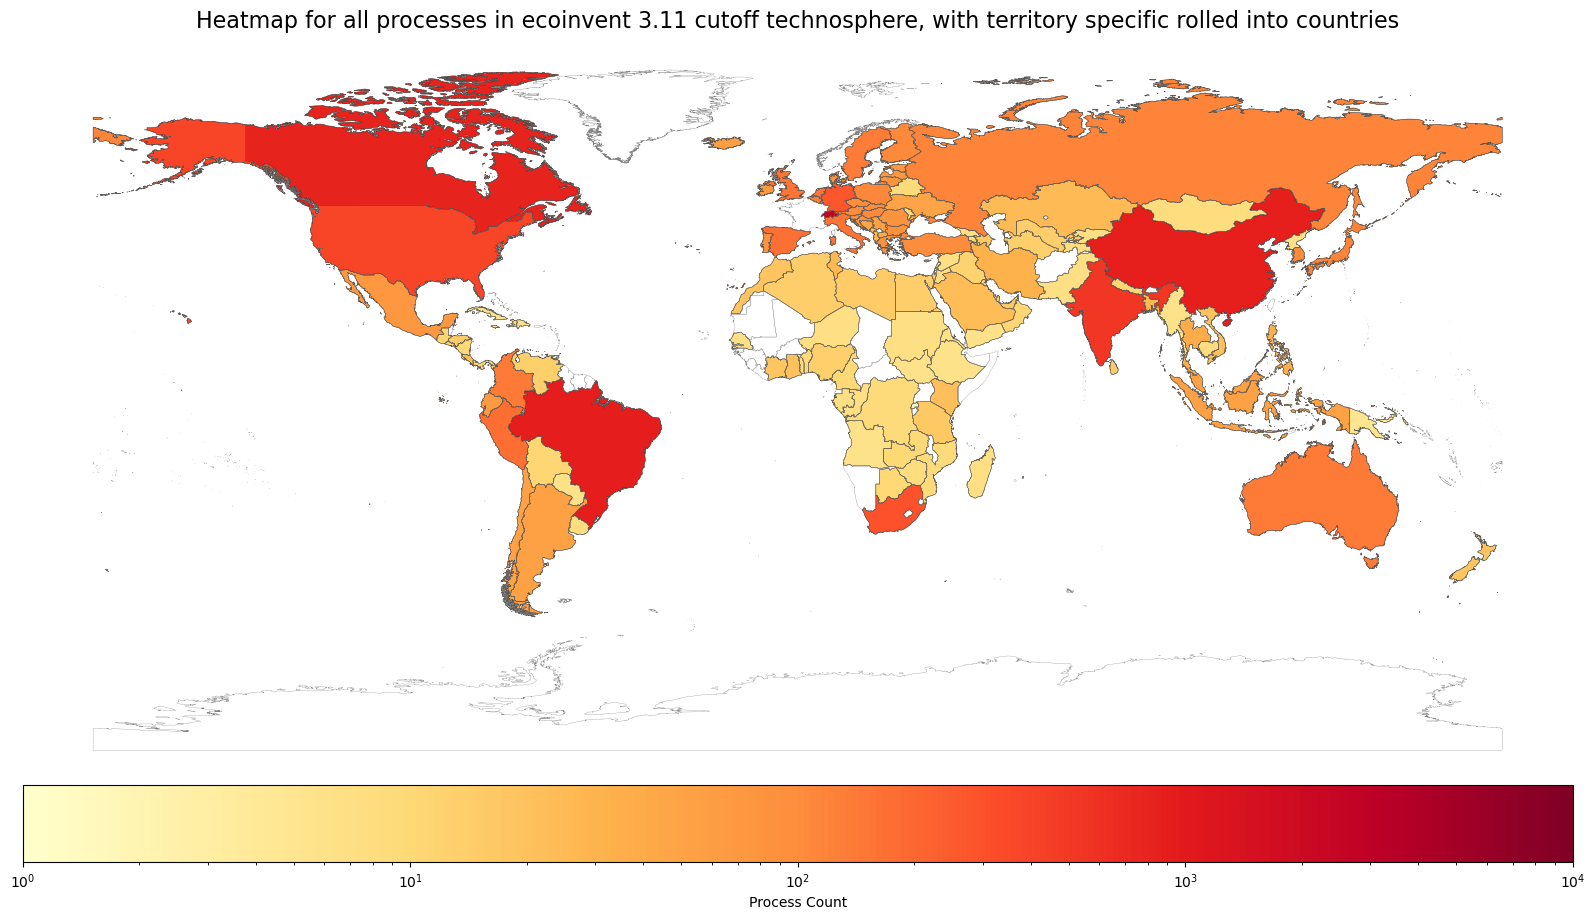

In [ ]:
for name, frame in frames.items():
        fig, ax = plt.subplots(1, figsize=(20, 22))
        plot_heatmap_frame(frame, ax)
        plt.title(f"Heatmap for {name}", fontsize=16)
        plt.savefig(f"{root}/Figures/Basic_Viz/Heatmaps/{name}.png")